In [3]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
#from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import keras
import json
from keras import layers, models
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from keras import layers
from keras.models import Model

## Load in Data

Get this data from unzipping the folder "LSTM_Inputs" in Google Drive!

In [ ]:
img_size, img_size_1 = '11', '11'
#30x31
size=img_size+'x'+img_size_1
start = datetime.datetime.now()
with open('11x11/processed_'+size+'/crashes_4d_24_hour.json', 'r') as f:
    array_4d_list = json.load(f)

# Convert the nested list back to a numpy array
array_4d_24_hour = np.array(array_4d_list)

with open('11x11/processed_'+size+'/crashes_4d_one_hour.json', 'r') as f:
    array_4d_list = json.load(f)
array_4d_1_hour = np.array(array_4d_list) 

binary_output_1_hour = (array_4d_1_hour > 0).astype(int)
print("Finished Loading in:", datetime.datetime.now()-start)

Finished Loading in: 0:00:23.532736


In [7]:
with open('weather_time_data/1_hour_weather_data_1_hot_with_hour.json', 'r') as f:
    weather_1_hour_list_with_hour = json.load(f)
weather_1_hour_with_hour = np.array(weather_1_hour_list_with_hour) 

In [5]:
binary_output_1hr_scalar = np.any(binary_output_1_hour > 0, axis=(1, 2, 3)).astype(int).reshape(-1, 1)

In [8]:
# Split into training and testing sets with 0.8-0.2
Accident_train, Accident_test, Traffic_train, Traffic_test, Weather_Hr_train, Weather_Hr_test, Out_train, Out_test, Binary_Out_train, Binary_Out_test = train_test_split(array_4d_24_hour, traffic_1_hour_normalized, weather_1_hour_with_hour, array_4d_1_hour, binary_output_1_hour, test_size=0.2, random_state=42)

In [10]:
# Save train-test splits using numpy
np.save('11x11/model_train_test_data/Accident_train.npy', Accident_train)
np.save('11x11/model_train_test_data/Accident_test.npy', Accident_test)
np.save('11x11/model_train_test_data/Traffic_train.npy', Traffic_train)
np.save('11x11/model_train_test_data/Traffic_test.npy', Traffic_test)
np.save('11x11/model_train_test_data/Weather_Hr_train.npy', Weather_Hr_train)
np.save('11x11/model_train_test_data/Weather_Hr_test.npy', Weather_Hr_test)
np.save('11x11/model_train_test_data/Out_train.npy', Out_train)
np.save('11x11/model_train_test_data/Out_test.npy', Out_test)
np.save('11x11/model_train_test_data/Binary_Out_train.npy', Binary_Out_train)
np.save('11x11/model_train_test_data/Binary_Out_test.npy', Binary_Out_test)

#To load back in as a numpy array
#Accident_train = np.load('Accident_train.npy')


## 1. Full Model - Regression

In [66]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(24, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)


#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='linear')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model = Model(inputs=[input_past_accidents_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 11, 11,    │     13,888 │ input_layer_27[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 3, 11, 64) │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 2112)      │          0 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 24)        │     50,712 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 24, 1)     │          0 │ dense_43[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │      1,536 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 24)        │      2,496 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 32)        │      2,080 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 16)        │        400 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 16)        │        528 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 16)        │          0 │ dense_44[0][0],   │
│ (Multiply)          │                   │            │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 121)       │      2,057 │ multiply_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 11, 11, 1) │          0 │ dense_48[0][0]    │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,697 (287.88 KB)

 Trainable params: 73,697 (287.88 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
## Split into training and testing sets with 0.8-0.2
history = model.fit([Accident_train, Weather_Hr_train], Out_train, epochs=50, batch_size=32)

Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1159 - mae: 0.1371
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1074 - mae: 0.1365
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1068 - mae: 0.1357
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1061 - mae: 0.1345
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1062 - mae: 0.1344
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1058 - mae: 0.1336
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1058 - mae: 0.1333
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1055 - mae: 0.1327
Epoch 9/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1054 - mae: 0.1326
Epoch 10/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1047 - mae: 0.1321
Epoch 11/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1051 - mae: 0.1325
Epoch 12/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1047 - mae: 0.1326
E

In [13]:
model.save('11x11/models_/full_regression_50_epochs.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

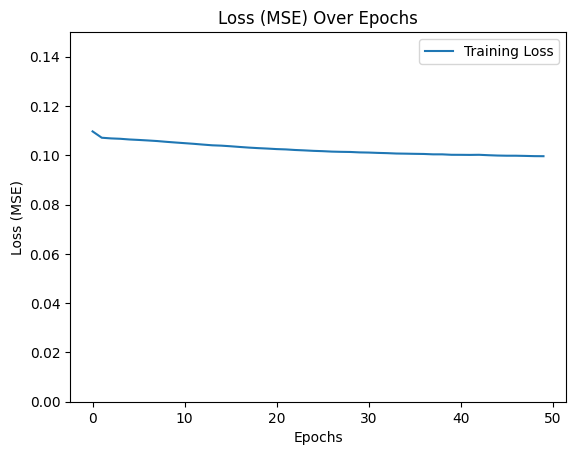

In [14]:
# Extract training and validation losses
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot both
plt.plot(train_loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.ylim(0, 0.15)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) Over Epochs')
plt.legend()
plt.show()

In [15]:
# Evaluate the model on the test set
train_loss, train_mae = model.evaluate([Accident_train, Weather_Hr_train], Out_train)

# Print the MAE
print(f"Train MSE: {train_loss}")
print(f"Train MAE: {train_mae}")

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0991 - mae: 0.1278
Train MSE: 0.09917116910219193
Train MAE: 0.12784862518310547


In [16]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Accident_test, Weather_Hr_test], Out_test)

# Print the MAE
print(f"Test MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1136 - mae: 0.1335
Test MSE: 0.112718865275383
Test MAE: 0.1326783299446106


In [17]:
predictions_test = model.predict([Accident_test, Weather_Hr_test])
predictions_train = model.predict([Accident_train, Weather_Hr_train])

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [18]:
np.save('11x11/models_/model_regression_test_predictions_values_50epochs.npy', predictions_test)
np.save('11x11/models_/model_regression_train_predictions_values_50epochs.npy', predictions_train)

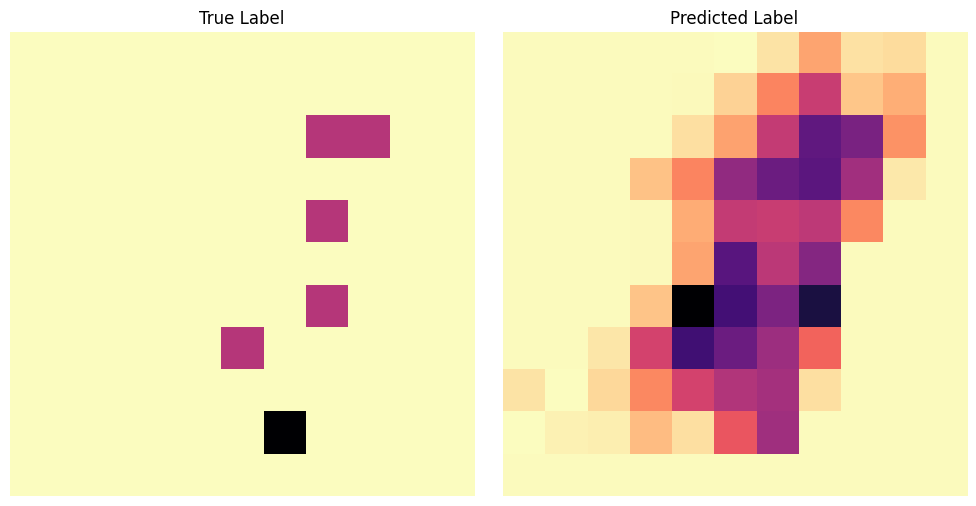

In [19]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot true label (Y_test[-1])
axes[0].imshow(Out_test[3640], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_test[3640], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


## 2. Full-Model Classification

In [70]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(24, return_sequences=False)(accidents_layer_7)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(24, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_8, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='sigmoid')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model_binary = Model(inputs=[input_past_accidents_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_binary.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 11, 11,    │     13,888 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 3, 11, 64) │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 2112)      │          0 │ max_pooling2d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 24)        │     50,712 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 64)        │      1,536 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_17          │ (None, 24, 1)     │          0 │ dense_53[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 32)        │      2,080 │ dense_54[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 24)        │      2,496 │ reshape_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 24)        │        792 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 24)        │          0 │ lstm_9[0][0],     │
│ (Multiply)          │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 121)       │      3,025 │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 11, 11, 1) │          0 │ dense_57[0][0]    │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,529 (291.13 KB)

 Trainable params: 74,529 (291.13 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
## Split into training and testing sets with 0.8-0.2
history_binary = model_binary.fit([Accident_train, Weather_Hr_train], Binary_Out_train, epochs=50, batch_size=32)

Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8907 - loss: 0.2653
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9242 - loss: 0.1732
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9242 - loss: 0.1732
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9244 - loss: 0.1726
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9241 - loss: 0.1729
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9245 - loss: 0.1724
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9246 - loss: 0.1726
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9246 - loss: 0.1722
Epoch 9/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9247 - loss: 0.1719
Epoch 10/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9241 - loss: 0.1729
Epoch 11/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9246 - loss: 0.1720
Epoch 12/50
1079/1079 ━━━━━━━━

In [30]:
print(model_binary.layers[1].get_weights()[-1])

[-0.25184825 -0.1339211  -0.1988988  -0.09972735 -0.19596039 -0.21314904
 -0.1281063  -0.04979005 -0.09871969 -0.06278493 -0.13273431 -0.05420429
 -0.23048337 -0.07470035 -0.16559479 -0.19557154 -0.19641101 -0.06861757
 -0.22524992 -0.08245119 -0.08451007 -0.21247585 -0.16056888 -0.16142406
 -0.26211515 -0.25377524 -0.10852897 -0.11759572 -0.14463742 -0.15816537
 -0.08040143 -0.02888865 -0.15162341 -0.10274559 -0.06003587 -0.10971858
 -0.10761677 -0.12879948 -0.07444509 -0.17812496 -0.17747764 -0.16787894
 -0.02943471 -0.11588585 -0.08227227 -0.21806988 -0.06057153 -0.09015513
 -0.12522896 -0.18880461 -0.04661382 -0.05240759 -0.20217007 -0.1200483
 -0.10802564 -0.02882886 -0.10359868 -0.09917247 -0.01439692 -0.10208302
 -0.06291954 -0.023943   -0.02698784 -0.08572274]


In [33]:
model_binary.save('11x11/models_/full_binary_50.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

In [34]:
train_loss, train_accuracy = model_binary.evaluate([Accident_train, Weather_Hr_train], Binary_Out_train)


1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9260 - loss: 0.1678


In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_binary.evaluate([Accident_test, Weather_Hr_test], Binary_Out_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9225 - loss: 0.1775
Test Loss: 0.1770462542772293
Test Accuracy: 0.9230139851570129


In [40]:
predictions_model_binary_test = model_binary.predict([Accident_test, Weather_Hr_test])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_test = (predictions_model_binary_test > 0.5).astype(int)

predictions_model_binary_train = model_binary.predict([Accident_train, Weather_Hr_train])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_train= (predictions_model_binary_train > 0.5).astype(int)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [41]:
np.save('11x11/models_/model_binary_test_predictions_values50.npy', binary_predictions_test)
np.save('11x11/models_/model_binary_train_predictions_values50.npy', binary_predictions_train)
np.save('11x11/models_/model_binary_test_predictions_probs50.npy', predictions_model_binary_test)
np.save('11x11/models_/model_binary_train_predictions_probs50.npy', predictions_model_binary_train)

In [89]:
string = "06/01/2020 04:00:00 PM"
string_no_spaces = string.replace(" ", "")  # Remove spaces
string_replaced = string_no_spaces.replace(":", "-")  # Replace ":" with "-"
print(string_replaced)

06/01/202004-00-00PM


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ch/Desktop/0_CS229_Final/06/01/202004-00-00PMmodel_50.png'

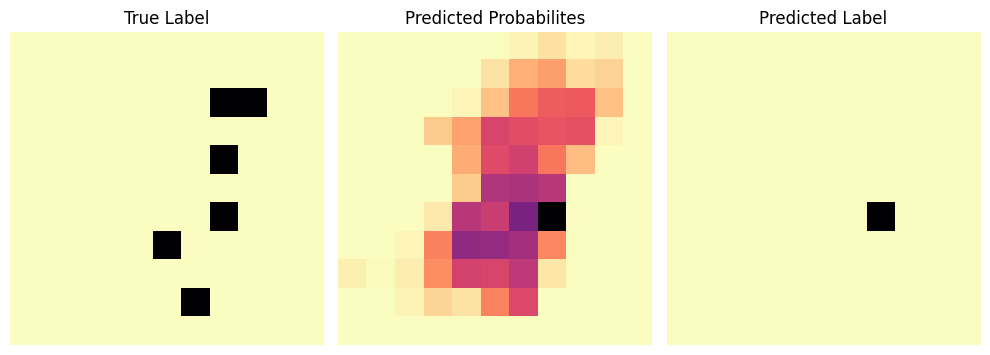

In [90]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))  # 1 row, 2 columns
i=3640

# Plot true label (Y_test[-1])
axes[0].imshow(Binary_Out_test[i], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_model_binary_test[i], cmap='magma_r')
axes[1].set_title("Predicted Probabilites")
axes[1].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[2].imshow(binary_predictions_test[i], cmap='magma_r')
axes[2].set_title("Predicted Label")
axes[2].axis('off')  # Hide axis for better visualization


# Show the plot
plt.tight_layout()  # Adjust spacing
plt.savefig(string_replaced+'model_50.png')
plt.show()


In [105]:
len(final_times['24_Hour_Intervals'])

43131

In [104]:
final_times['1_hour_Intervals']['0']

['01/02/2020 12:00:00 AM', '01/02/2020 01:00:00 AM']

In [100]:
final_times['1_hour_Intervals'][str(len(final_times['1_hour_Intervals'])-1)]

['12/03/2024 02:00:00 AM', '12/03/2024 03:00:00 AM']

In [99]:
len(final_times['24_Hour_Intervals'])

43131

In [69]:
with open('final_time_intervals.json', 'r') as f:
    final_times = json.load(f)
len(final_times)-5000

-4998

### Plot ROC Curve On Test Data

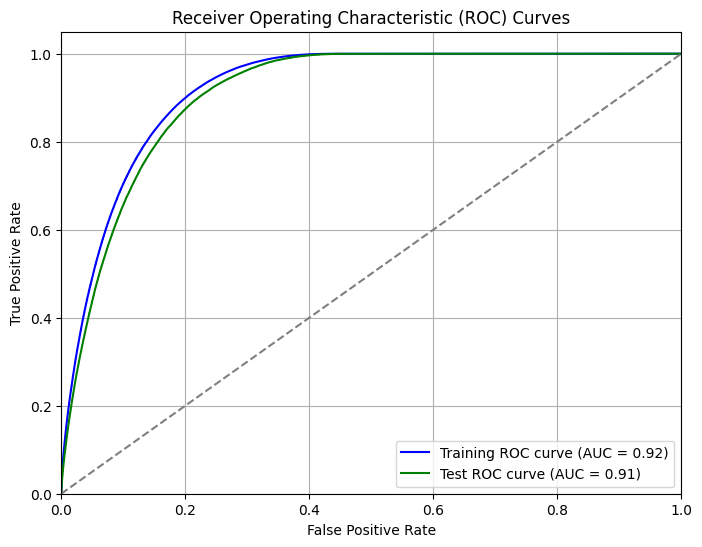

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))

# Plot training set ROC curve
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')

# Plot testing set ROC curve
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Diagonal line representing random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [48]:
binary_predictions_test.shape, Binary_Out_test_flattened.shape

((8627, 11, 11, 1), (1043867,))

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_test = confusion_matrix(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))#.ravel()
cm_train = confusion_matrix(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))#.ravel()


In [93]:
TN, FP, FN, TP = cm_test.ravel()
TN, FP, FN, TP

(951084, 10580, 69783, 12420)

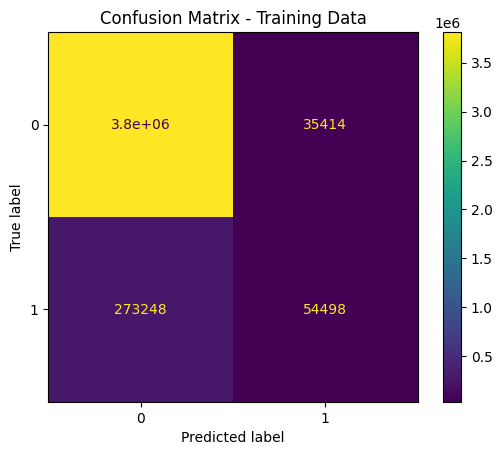

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

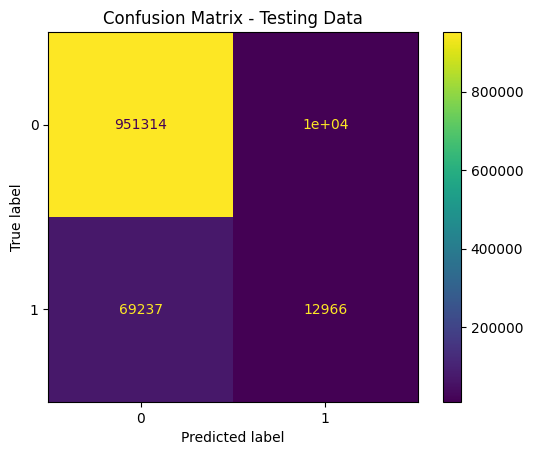

In [328]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()

In [51]:
precision_train = precision_score(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))
recall_train = recall_score(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))
precision_train, recall_train, train_accuracy

(0.6061259898567488, 0.16628120556772621, 0.9260678291320801)

In [55]:
precision_test = precision_score(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))
recall_test = recall_score(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))
precision_test, recall_test, test_accuracy

(0.54, 0.15108937630013503, 0.9230139851570129)

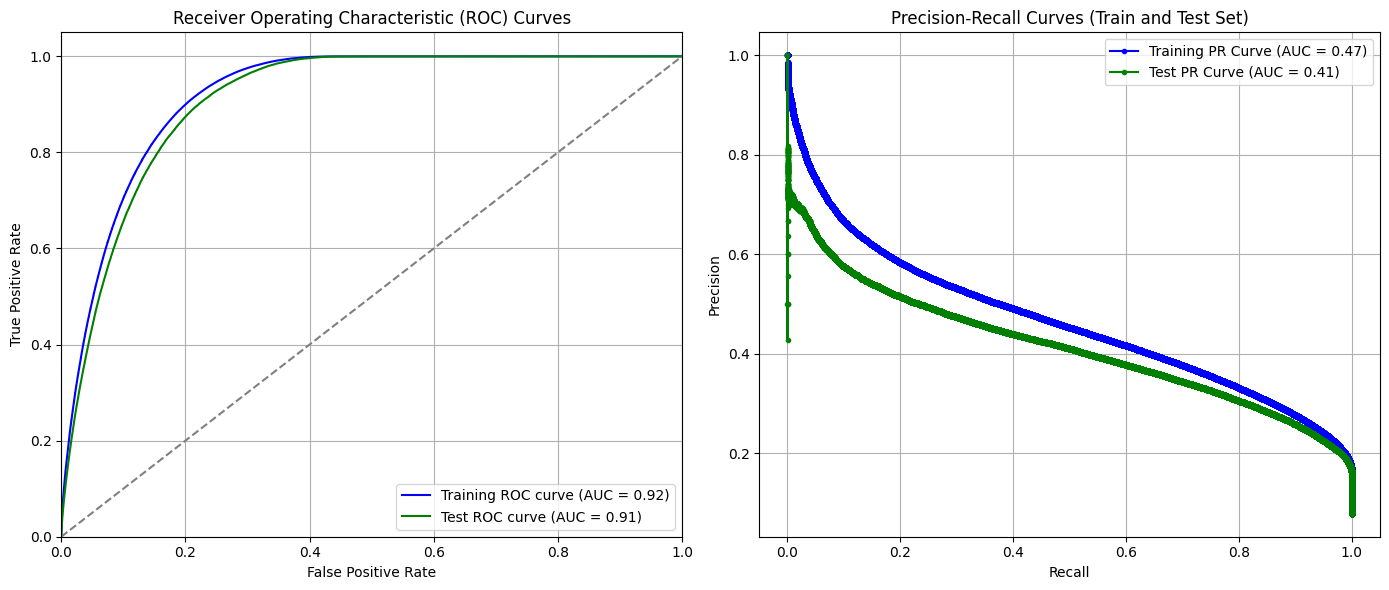

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Calculate precision, recall, and thresholds for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)

# Calculate the area under the Precision-Recall curve (PR AUC) for the training set
pr_auc_train = auc(recall_train, precision_train)

# Calculate precision, recall, and thresholds for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)

# Calculate the area under the Precision-Recall curve (PR AUC) for the test set
pr_auc_test = auc(recall_test, precision_test)

# Plot both ROC curve and Precision-Recall curve in one figure with subplots
plt.figure(figsize=(14, 6))

# Subplot 1: ROC curve
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot 2: Precision-Recall curve
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(recall_train, precision_train, marker='.', color='b', label=f'Training PR Curve (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, marker='.', color='g', label=f'Test PR Curve (AUC = {pr_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves (Train and Test Set)')
plt.grid(True)
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()


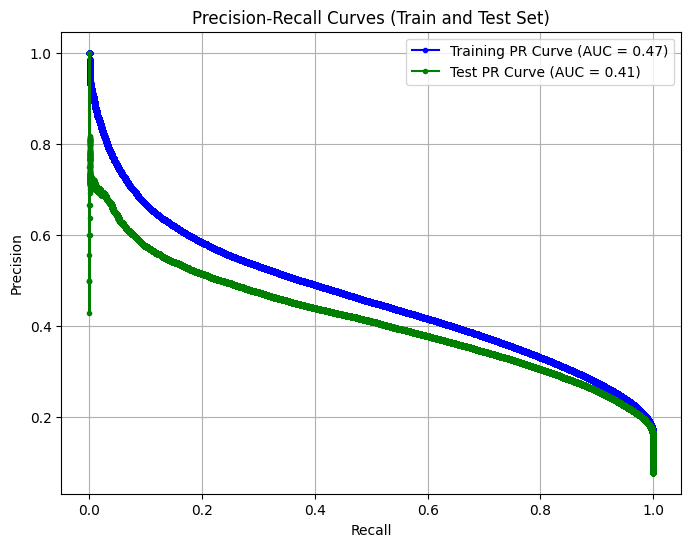

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, auc

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))

# Plot training set ROC curve
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')

# Plot testing set ROC curve
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Diagonal line representing random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()
# Calculate precision, recall, and thresholds for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(Binary_Out_train_flattened, predictions_model_binary_train.reshape(-1))

# Calculate the area under the Precision-Recall curve (PR AUC) for the training set
pr_auc_train = auc(recall_train, precision_train)

# Calculate precision, recall, and thresholds for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(Binary_Out_test_flattened, predictions_model_binary_test.reshape(-1))

# Calculate the area under the Precision-Recall curve (PR AUC) for the test set
pr_auc_test = auc(recall_test, precision_test)

# Plot Precision-Recall curve for both training and test sets
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, marker='.', color='b', label=f'Training PR Curve (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, marker='.', color='g', label=f'Test PR Curve (AUC = {pr_auc_test:.2f})')

# Adding labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves (Train and Test Set)')

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


## 3. Regression Model (No Spatial)

In [31]:
crashes = pd.read_csv("raw_data/Traffic_Crashes_-_Crashes_20241203.csv")

In [91]:
gps_epoch = datetime.datetime(1980, 1, 6, 0, 0, 0)crashes_lakefront=crashes

SyntaxError: invalid syntax (3058142745.py, line 1)

(array([12578.,     0., 10705.,     0.,  8895.,     0.,  7362.,     0.,
         6316.,     0.,  7133.,     0.,     0., 10624.,     0., 20547.,
            0., 25861.,     0., 22771.,     0., 23528.,     0., 26722.,
            0.,     0., 30756.,     0., 31475.,     0., 34871.,     0.,
        40923.,     0., 40058.,     0., 38394.,     0.,     0., 31758.,
            0., 23847.,     0., 19875.,     0., 17636.,     0., 16116.,
            0., 14496.]),
 array([ 0.  ,  0.46,  0.92,  1.38,  1.84,  2.3 ,  2.76,  3.22,  3.68,
         4.14,  4.6 ,  5.06,  5.52,  5.98,  6.44,  6.9 ,  7.36,  7.82,
         8.28,  8.74,  9.2 ,  9.66, 10.12, 10.58, 11.04, 11.5 , 11.96,
        12.42, 12.88, 13.34, 13.8 , 14.26, 14.72, 15.18, 15.64, 16.1 ,
        16.56, 17.02, 17.48, 17.94, 18.4 , 18.86, 19.32, 19.78, 20.24,
        20.7 , 21.16, 21.62, 22.08, 22.54, 23.  ]),
 <BarContainer object of 50 artists>)

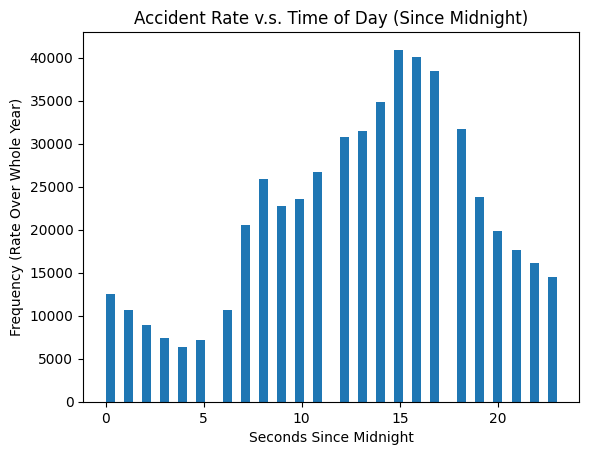

In [92]:
plt.ylabel("Frequency (Rate Over Whole Year)")
plt.xlabel("Seconds Since Midnight")
plt.title("Accident Rate v.s. Time of Day (Since Midnight)")
plt.hist(crashes_lakefront['CRASH_HOUR'], bins=50)

In [93]:
crashes_lakefront_time_midnight= []
for index, row in crashes_lakefront.iterrows():
    time = row['CRASH_DATE'][-11:]
    #print(time)
    time_obj = datetime.datetime.strptime(time, "%I:%M:%S %p")
    #time_24hr = time_obj.strftime("%H:%M:%S")
    seconds_since_midnight = (time_obj - datetime.datetime.combine(time_obj.date(), datetime.datetime.min.time())).seconds

    crashes_lakefront_time_midnight.append(seconds_since_midnight)
crashes_lakefront['Time_from_Midnight'] = crashes_lakefront_time_midnight

In [94]:
seconds_i=0
time_data_crashes = []
traffic = []
inc = 30
counts = []
while seconds_i < 1440:
    #print(crashes_lakefront)
    counts_i = len(crashes_lakefront[(crashes_lakefront['Time_from_Midnight']>=seconds_i) & (crashes_lakefront['Time_from_Midnight']<=inc+seconds_i)])
    counts.append(counts_i)
    #traffic_data_filt = traffic_lakefront[(traffic_lakefront['Time_from_Midnight']>=seconds_i) & (traffic_lakefront['Time_from_Midnight']<=inc+seconds_i)]
    #traffic.append(np.mean(traffic_data_filt['SPEED']))
    time_data_crashes.append((2*seconds_i+inc)/2)
    seconds_i+=inc

crash_time_data_transformed = [time_data_crashes[i] for i in range(len(time_data_crashes))]

In [95]:
list1 = crash_time_data_transformed
import random
list2 = counts

# Pair the items from both lists by index
paired_lists = list(zip(list1, list2))

# Calculate the number of pairs to sample (80% of the total number of pairs)
sample_size = int(len(paired_lists) * 0.8)

# Randomly sample 80% of the paired items
sampled_pairs = random.sample(paired_lists, sample_size)
non_sampled_pairs = [pair for pair in paired_lists if pair not in sampled_pairs]

# Unzip the sampled pairs back into two lists (if needed)
sampled_list1, sampled_list2 = zip(*sampled_pairs)
non_sampled_list1, non_sampled_list2 = zip(*non_sampled_pairs) if non_sampled_pairs else ([], [])

# Output the results
train_X, train_y  = sampled_list1, sampled_list2
test_X, test_y = non_sampled_list1, non_sampled_list2
print(f"Sampled pairs: {sampled_pairs}")
print(f"Sampled list1: {sampled_list1}")
print(f"Sampled list2: {sampled_list2}")

print(f"\nNon-sampled pairs: {non_sampled_pairs}")
print(f"Non-sampled list1: {non_sampled_list1}")
print(f"Non-sampled list2: {non_sampled_list2}")

Sampled pairs: [(1215.0, 489), (1155.0, 95), (15.0, 1683), (45.0, 1114), (645.0, 92), (345.0, 106), (825.0, 95), (165.0, 123), (1335.0, 91), (855.0, 95), (675.0, 92), (795.0, 88), (315.0, 440), (945.0, 79), (1395.0, 115), (285.0, 440), (1125.0, 95), (225.0, 111), (885.0, 612), (765.0, 88), (1065.0, 103), (1035.0, 103), (495.0, 114), (405.0, 115), (1365.0, 115), (1305.0, 91), (585.0, 449), (75.0, 1114), (195.0, 123), (1245.0, 83), (705.0, 139), (735.0, 139), (555.0, 93), (915.0, 612), (1005.0, 103), (465.0, 114), (255.0, 111), (1095.0, 103)]
Sampled list1: (1215.0, 1155.0, 15.0, 45.0, 645.0, 345.0, 825.0, 165.0, 1335.0, 855.0, 675.0, 795.0, 315.0, 945.0, 1395.0, 285.0, 1125.0, 225.0, 885.0, 765.0, 1065.0, 1035.0, 495.0, 405.0, 1365.0, 1305.0, 585.0, 75.0, 195.0, 1245.0, 705.0, 735.0, 555.0, 915.0, 1005.0, 465.0, 255.0, 1095.0)
Sampled list2: (489, 95, 1683, 1114, 92, 106, 95, 123, 91, 95, 92, 88, 440, 79, 115, 440, 95, 111, 612, 88, 103, 103, 114, 115, 115, 91, 449, 1114, 123, 83, 139, 

/var/folders/6d/ffdjbx496k5dqjgrkzxf2zlw0000gp/T/ipykernel_2441/454598901.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x', color='black')  # Dashed line


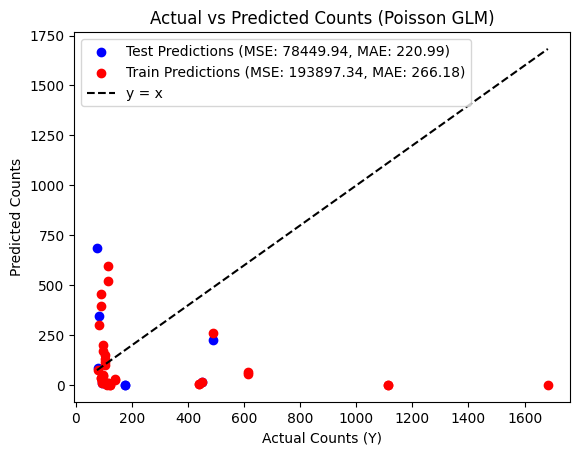

In [97]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate some data (for example: 100 samples, 2 predictors)
# Fit Poisson GLM model
train_X, train_y  = sampled_list1, sampled_list2
test_X, test_y = non_sampled_list1, non_sampled_list2
# Fit the Poisson GLM model
poisson_model = sm.GLM(train_y, train_X, family=Poisson()).fit()

# Make predictions using the fitted model
test_predictions = poisson_model.predict(test_X)
train_predictions = poisson_model.predict(train_X)

# Calculate MSE and MAE for the test data
mse_test = mean_squared_error(test_y, test_predictions)
mae_test = mean_absolute_error(test_y, test_predictions)

# Calculate MSE and MAE for the train data
mse_train = mean_squared_error(train_y, train_predictions)
mae_train = mean_absolute_error(train_y, train_predictions)

# Create legend labels with MSE and MAE values
test_label = f'Test Predictions (MSE: {mse_test:.2f}, MAE: {mae_test:.2f})'
train_label = f'Train Predictions (MSE: {mse_train:.2f}, MAE: {mae_train:.2f})'

# Visualizing the actual vs predicted counts
plt.scatter(test_y, test_predictions, label=test_label, color='blue')
plt.scatter(train_y, train_predictions, label=train_label, color='red')
# Add the y = x line (diagonal line)
min_val = min(min(test_y), min(train_y))  # Min value to set the axis limits
max_val = max(max(test_y), max(train_y))  # Max value to set the axis limits
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x', color='black')  # Dashed line

# Adding labels and title
plt.xlabel("Actual Counts (Y)")
plt.ylabel("Predicted Counts")
plt.title("Actual vs Predicted Counts (Poisson GLM)")

# Adding a legend
plt.legend()

# Show the plot
plt.show()